In [ ]:
import zipfile
import pandas as pd
import io
import random
from google.colab import files

# Step 1: Upload ZIPs
uploaded = files.upload()
print("Uploaded files:", uploaded.keys())

# Step 2: Match uploaded files to fraud and non-fraud
def find_zip_file(substring):
    for name in uploaded.keys():
        if substring.lower() in name.lower():
            return name
    raise ValueError(f"No uploaded file matches '{substring}'")

fraud_zip_name = find_zip_file("Fraud")
nonfraud_zip_name = find_zip_file("Non-fraud")

# Step 3: Load and sample
def load_zip_and_sample(zip_name, label, sample_size=150):
    text_list = []
    label_list = []

    with zipfile.ZipFile(io.BytesIO(uploaded[zip_name]), 'r') as zf:
        file_names = zf.namelist()
        sampled_files = random.sample(file_names, min(sample_size, len(file_names)))

        for fname in sampled_files:
            with zf.open(fname) as f:
                try:
                    content = f.read().decode('utf-8', errors='ignore')
                    text_list.append(content)
                    label_list.append(label)
                except Exception as e:
                    print(f"Skipping file {fname}: {e}")

    return pd.DataFrame({'text': text_list, 'label': label_list})

df_fraud = load_zip_and_sample(fraud_zip_name, label=1)
df_nonfraud = load_zip_and_sample(nonfraud_zip_name, label=0)

# Step 4: Combine and shuffle
df = pd.concat([df_fraud, df_nonfraud]).sample(frac=1, random_state=42).reset_index(drop=True)

print(df['label'].value_counts())
df.head()


Saving Fraud_MDA_Summarized 3.zip to Fraud_MDA_Summarized 3 (1).zip
Saving Non-fraud_MDA_Summarized 2.zip to Non-fraud_MDA_Summarized 2 (1).zip
Uploaded files: dict_keys(['Fraud_MDA_Summarized 3 (1).zip', 'Non-fraud_MDA_Summarized 2 (1).zip'])
label
0    150
1    150
Name: count, dtype: int64


,text,label
0,"Based on the provided summaries, the company's...",0
1,    Mac OS X     \t   2   ~      ...,0
2,    Mac OS X     \t   2   ~      ...,0
3,The company has demonstrated significant growt...,1
4,    Mac OS X     \t   2   ~      ...,0


#Distilbert

In [ ]:
# -------------------- 1. Install Dependencies --------------------
!pip install -q transformers datasets scikit-learn

# -------------------- 2. Imports --------------------
import torch
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    TrainingArguments,
    Trainer
)
from datasets import Dataset
import torch.nn as nn

# -------------------- 3. Setup --------------------
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------------------- 4. Prepare Data --------------------
# Assume df is already loaded and cleaned with 'text' and 'label' columns
df['label'] = df['label'].astype(int)
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=SEED)

# Convert to HuggingFace Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# -------------------- 5. Tokenizer --------------------
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=512)

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

# Required for Trainer API
train_dataset = train_dataset.remove_columns(["text", "__index_level_0__"])
val_dataset = val_dataset.remove_columns(["text", "__index_level_0__"])
train_dataset.set_format("torch")
val_dataset.set_format("torch")

# -------------------- 6. Model --------------------
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Compute class weights
weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=train_df['label'].values)
class_weights = torch.tensor(weights, dtype=torch.float).to(device)

# -------------------- 7. Custom Trainer --------------------
class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs["labels"]
        outputs = model(**{k: v for k, v in inputs.items() if k != "labels"})
        logits = outputs.logits
        loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

# -------------------- 8. Trainer Arguments --------------------
training_args = TrainingArguments(
    output_dir="./distilbert-mdna",
    num_train_epochs=4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=1,
    report_to="none",
    seed=SEED
)

# -------------------- 9. Trainer Setup --------------------
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    class_weights=class_weights
)

# -------------------- 10. Train --------------------
trainer.train()

# -------------------- 11. Evaluate --------------------
preds_output = trainer.predict(val_dataset)
preds = np.argmax(preds_output.predictions, axis=1)
true_labels = preds_output.label_ids

print("\nClassification Report:")
print(classification_report(true_labels, preds, digits=4))

print("\nConfusion Matrix:")
print(confusion_matrix(true_labels, preds))


Device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/240 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2067067607.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss
1,0.697700,0.673530
2,0.621400,0.478732
3,0.403300,0.348440
4,0.312100,0.328538



Classification Report:
              precision    recall  f1-score   support

           0     0.9200    0.7667    0.8364        30
           1     0.8000    0.9333    0.8615        30

    accuracy                         0.8500        60
   macro avg     0.8600    0.8500    0.8490        60
weighted avg     0.8600    0.8500    0.8490        60


Confusion Matrix:
[[23  7]
 [ 2 28]]


#FinBERT

In [ ]:
# -------------------- 1. Install Dependencies --------------------
!pip install -q transformers datasets scikit-learn

# -------------------- 2. Imports --------------------
import torch
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from datasets import Dataset
import torch.nn as nn

# -------------------- 3. Setup --------------------
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------------------- 4. Prepare Data --------------------
df['label'] = df['label'].astype(int)
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=SEED)

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# -------------------- 5. Tokenizer --------------------
model_name = "yiyanghkust/finbert-pretrain"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=512)

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

train_dataset = train_dataset.remove_columns(["text", "__index_level_0__"])
val_dataset = val_dataset.remove_columns(["text", "__index_level_0__"])
train_dataset.set_format("torch")
val_dataset.set_format("torch")

# -------------------- 6. Model --------------------
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Compute class weights
weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=train_df['label'].values)
class_weights = torch.tensor(weights, dtype=torch.float).to(device)

# -------------------- 7. Custom Trainer --------------------
class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):  # ✅ accepts extra args
        labels = inputs["labels"]
        outputs = model(**{k: v for k, v in inputs.items() if k != "labels"})
        logits = outputs.logits
        loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

# -------------------- 8. Trainer Arguments --------------------
training_args = TrainingArguments(
    output_dir="./finbert-mdna",
    num_train_epochs=4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=1,
    report_to="none",
    seed=SEED
)

# -------------------- 9. Trainer Setup --------------------
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    class_weights=class_weights
)

# -------------------- 10. Train --------------------
trainer.train()

# -------------------- 11. Evaluate --------------------
preds_output = trainer.predict(val_dataset)
preds = np.argmax(preds_output.predictions, axis=1)
true_labels = preds_output.label_ids

print("\nClassification Report:")
print(classification_report(true_labels, preds, digits=4))

print("\nConfusion Matrix:")
print(confusion_matrix(true_labels, preds))


Device: cuda


Map:   0%|          | 0/240 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1106189565.py:61: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss
1,0.653300,0.407459
2,0.312400,0.316998
3,0.213800,0.280319
4,0.155300,0.262874


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



Classification Report:
              precision    recall  f1-score   support

           0     0.8929    0.8333    0.8621        30
           1     0.8438    0.9000    0.8710        30

    accuracy                         0.8667        60
   macro avg     0.8683    0.8667    0.8665        60
weighted avg     0.8683    0.8667    0.8665        60


Confusion Matrix:
[[25  5]
 [ 3 27]]


#Debrta-small

In [ ]:
# -------------------- 1. Install Dependencies --------------------
!pip install -q transformers datasets scikit-learn

# -------------------- 2. Imports --------------------
import torch
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from datasets import Dataset
import torch.nn as nn

# -------------------- 3. Setup --------------------
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------------------- 4. Prepare Data --------------------
df['label'] = df['label'].astype(int)
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=SEED)

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# -------------------- 5. Tokenizer --------------------
model_name = "microsoft/deberta-v3-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=512)

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

train_dataset = train_dataset.remove_columns(["text", "__index_level_0__"])
val_dataset = val_dataset.remove_columns(["text", "__index_level_0__"])
train_dataset.set_format("torch")
val_dataset.set_format("torch")

# -------------------- 6. Model --------------------
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Compute class weights
weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=train_df['label'].values)
class_weights = torch.tensor(weights, dtype=torch.float).to(device)

# -------------------- 7. Custom Trainer --------------------
class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs["labels"]
        outputs = model(**{k: v for k, v in inputs.items() if k != "labels"})
        logits = outputs.logits
        loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

# -------------------- 8. Trainer Arguments --------------------
training_args = TrainingArguments(
    output_dir="./deberta-mdna",
    num_train_epochs=4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=1,
    report_to="none",
    seed=SEED
)

# -------------------- 9. Trainer Setup --------------------
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    class_weights=class_weights
)

# -------------------- 10. Train --------------------
trainer.train()

# -------------------- 11. Evaluate --------------------
preds_output = trainer.predict(val_dataset)
preds = np.argmax(preds_output.predictions, axis=1)
true_labels = preds_output.label_ids

print("\nClassification Report:")
print(classification_report(true_labels, preds, digits=4))

print("\nConfusion Matrix:")
print(confusion_matrix(true_labels, preds))


Device: cuda


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/240 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3108840437.py:61: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss
1,0.709200,0.693716
2,0.694700,0.686790
3,0.675400,0.629024
4,0.606400,0.569917


model.safetensors:   0%|          | 0.00/286M [00:00<?, ?B/s]


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.5000    0.6667        30
           1     0.6667    1.0000    0.8000        30

    accuracy                         0.7500        60
   macro avg     0.8333    0.7500    0.7333        60
weighted avg     0.8333    0.7500    0.7333        60


Confusion Matrix:
[[15 15]
 [ 0 30]]


#Deberta small v2

Device: cuda


/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/240 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1837803682.py:61: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss
1,0.709100,0.693716
2,0.694700,0.686790
3,0.675400,0.629024
4,0.606400,0.569917



🔧 Best threshold = 0.54 with F1 = 0.8437


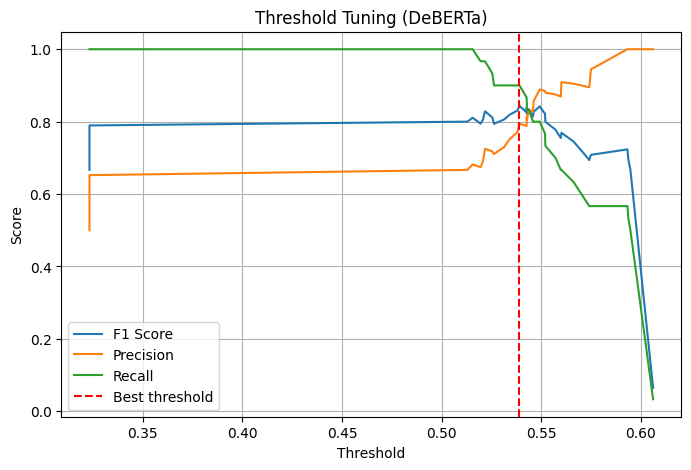


📊 Classification Report (tuned threshold):
              precision    recall  f1-score   support

           0     0.8846    0.7667    0.8214        30
           1     0.7941    0.9000    0.8438        30

    accuracy                         0.8333        60
   macro avg     0.8394    0.8333    0.8326        60
weighted avg     0.8394    0.8333    0.8326        60


📉 Confusion Matrix:
[[23  7]
 [ 3 27]]


In [ ]:
# -------------------- 1. Install Dependencies --------------------
!pip install -q transformers datasets scikit-learn matplotlib

# -------------------- 2. Imports --------------------
import torch
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from datasets import Dataset
import torch.nn as nn

# -------------------- 3. Setup --------------------
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------------------- 4. Prepare Data --------------------
df['label'] = df['label'].astype(int)
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=SEED)
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# -------------------- 5. Tokenizer --------------------
model_name = "microsoft/deberta-v3-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=512)

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

train_dataset = train_dataset.remove_columns(["text", "__index_level_0__"])
val_dataset = val_dataset.remove_columns(["text", "__index_level_0__"])
train_dataset.set_format("torch")
val_dataset.set_format("torch")

# -------------------- 6. Load Model --------------------
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# -------------------- 7. Compute Class Weights --------------------
weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=train_df['label'].values)
class_weights = torch.tensor(weights, dtype=torch.float).to(device)

# -------------------- 8. Custom Trainer --------------------
class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs["labels"]
        outputs = model(**{k: v for k, v in inputs.items() if k != "labels"})
        logits = outputs.logits
        loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

# -------------------- 9. Training Args --------------------
training_args = TrainingArguments(
    output_dir="./deberta-mdna-tuned",
    num_train_epochs=4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=1,
    report_to="none",
    seed=SEED
)

# -------------------- 10. Train --------------------
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    class_weights=class_weights
)
trainer.train()

# -------------------- 11. Predict Probabilities --------------------
preds_output = trainer.predict(val_dataset)
probs = torch.softmax(torch.tensor(preds_output.predictions), dim=1)[:, 1].numpy()
true_labels = preds_output.label_ids

# -------------------- 12. Threshold Tuning --------------------
precision, recall, thresholds = precision_recall_curve(true_labels, probs)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"\n🔧 Best threshold = {best_threshold:.2f} with F1 = {f1_scores[best_idx]:.4f}")

# Plot
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores[:-1], label="F1 Score")
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.axvline(best_threshold, color='r', linestyle='--', label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Tuning (DeBERTa)")
plt.legend()
plt.grid()
plt.show()

# -------------------- 13. Final Evaluation --------------------
# Either use best_threshold OR manually override it
final_threshold = best_threshold  # or manually set: final_threshold = 0.55

final_preds = (probs >= final_threshold).astype(int)

print("\n📊 Classification Report (tuned threshold):")
print(classification_report(true_labels, final_preds, digits=4))

print("\n📉 Confusion Matrix:")
print(confusion_matrix(true_labels, final_preds))


#DeBERTa v3 (Tuned - best)

Device: cuda


/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/240 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4176245448.py:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss
1,0.706700,0.693057
2,0.694200,0.685559
3,0.660900,0.598758
4,0.558800,0.530638



🔧 Best threshold = 0.49 with F1 = 0.8710


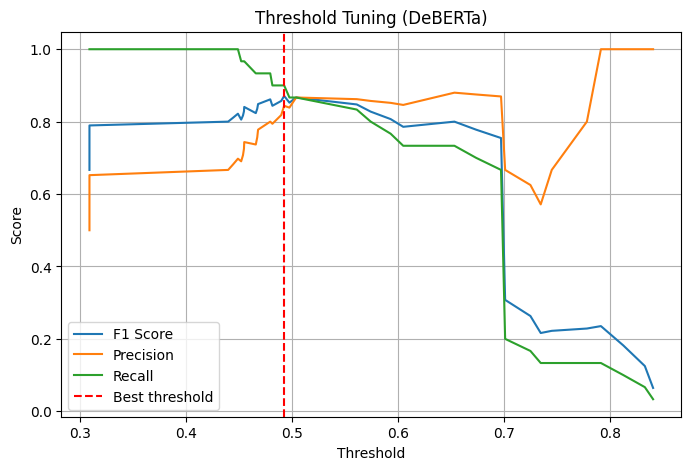


📊 Classification Report (tuned threshold):
              precision    recall  f1-score   support

           0     0.8929    0.8333    0.8621        30
           1     0.8438    0.9000    0.8710        30

    accuracy                         0.8667        60
   macro avg     0.8683    0.8667    0.8665        60
weighted avg     0.8683    0.8667    0.8665        60


📉 Confusion Matrix:
[[25  5]
 [ 3 27]]

🔍 False Positives:
 5     The company has experienced significant financ...
12    Summary:\n\nFinancial Health:\nThe company exp...
Name: text, dtype: object

🔍 False Negatives:
 6     The company had a strong financial performance...
18    The company has a strong credit rating, provid...
Name: text, dtype: object


In [ ]:
# -------------------- 1. Install Dependencies --------------------
!pip install -q transformers datasets scikit-learn matplotlib

# -------------------- 2. Imports --------------------
import torch
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from datasets import Dataset
import torch.nn as nn

# -------------------- 3. Setup --------------------
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------------------- 4. Prepare Data --------------------
df['label'] = df['label'].astype(int)
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=SEED)
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# -------------------- 5. Tokenizer --------------------
model_name = "microsoft/deberta-v3-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=512)

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

train_dataset = train_dataset.remove_columns(["text", "__index_level_0__"])
val_dataset = val_dataset.remove_columns(["text", "__index_level_0__"])
train_dataset.set_format("torch")
val_dataset.set_format("torch")

# -------------------- 6. Load Model --------------------
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# -------------------- 7. Compute Class Weights (with clipping) --------------------
weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=train_df['label'].values)
weights = np.clip(weights, 0.5, 2.0)  # smol change
class_weights = torch.tensor(weights, dtype=torch.float).to(device)

# -------------------- 8. Custom Trainer with Label Smoothing --------------------
class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs["labels"]
        outputs = model(**{k: v for k, v in inputs.items() if k != "labels"})
        logits = outputs.logits
        loss_fn = nn.CrossEntropyLoss(weight=self.class_weights, label_smoothing=0.1)  # smol change
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

# -------------------- 9. Training Args --------------------
training_args = TrainingArguments(
    output_dir="./deberta-mdna-tuned",
    num_train_epochs=4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=1,
    report_to="none",
    seed=SEED,
    warmup_ratio=0.1,  # smol change
    lr_scheduler_type="linear",  # smol change
)

# -------------------- 10. Trainer Setup with Early Stopping --------------------
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    class_weights=class_weights,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]  # smol change
)

# -------------------- 11. Train --------------------
trainer.train()

# -------------------- 12. Predict Probabilities --------------------
preds_output = trainer.predict(val_dataset)
probs = torch.softmax(torch.tensor(preds_output.predictions), dim=1)[:, 1].numpy()
true_labels = preds_output.label_ids

# -------------------- 13. Threshold Tuning --------------------
precision, recall, thresholds = precision_recall_curve(true_labels, probs)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"\n🔧 Best threshold = {best_threshold:.2f} with F1 = {f1_scores[best_idx]:.4f}")

# Plot
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores[:-1], label="F1 Score")
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.axvline(best_threshold, color='r', linestyle='--', label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Tuning (DeBERTa)")
plt.legend()
plt.grid()
plt.show()

# -------------------- 14. Final Evaluation --------------------
final_threshold = best_threshold  # or manually override
final_preds = (probs >= final_threshold).astype(int)

print("\n📊 Classification Report (tuned threshold):")
print(classification_report(true_labels, final_preds, digits=4))

print("\n📉 Confusion Matrix:")
print(confusion_matrix(true_labels, final_preds))

# -------------------- 15. Optional: Show Misclassified Samples --------------------
val_df = val_df.reset_index(drop=True)
val_df["pred"] = final_preds
val_df["prob"] = probs

fp = val_df[(val_df.label == 0) & (val_df.pred == 1)]
fn = val_df[(val_df.label == 1) & (val_df.pred == 0)]

print("\n🔍 False Positives:\n", fp["text"].head(2))
print("\n🔍 False Negatives:\n", fn["text"].head(2))


#Transfer learning

###Finebert

In [ ]:
# ---------------------------------------------------------------
# Stage 1: FinBERT on Fake/True News (Transfer Learning Pretrain)
# ---------------------------------------------------------------
# Usage: just run this file. Adjust the CSV paths or hyperparams below if needed.

import os
import io
import sys
import math
import json
import random
from dataclasses import dataclass
from typing import Dict, Any, List

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, precision_recall_curve
)
from sklearn.utils.class_weight import compute_class_weight

import torch
from torch.nn import CrossEntropyLoss

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    set_seed
)

# -----------------------------
# Config (change if you want)
# -----------------------------
SEED = 42
MODEL_NAME = "yiyanghkust/finbert-pretrain"   # Base FinBERT
OUTPUT_DIR = "./finbert-fake-news"            # Where to save the trained model
FAKE_CSV = "./Fake.csv"                       # <- change if your files are elsewhere
TRUE_CSV = "./True.csv"                       # <- change if your files are elsewhere

# If running where you uploaded:
if os.path.exists("/mnt/data/Fake.csv") and os.path.exists("/mnt/data/True.csv"):
    FAKE_CSV = "/mnt/data/Fake.csv"
    TRUE_CSV = "/mnt/data/True.csv"

MAX_LENGTH = 256
BATCH_SIZE = 8
EPOCHS = 3
LR = 2e-5
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.06
PATIENCE = 1              # Early stopping patience (in eval steps)

# Which text columns to concatenate (adjust to your CSV headers)
TEXT_COLS = ["title", "text"]

# -----------------------------
# Utilities
# -----------------------------
def set_all_seeds(seed: int = 42):
    set_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def read_news_csv(path: str, label: int) -> pd.DataFrame:
    df = pd.read_csv(path)
    df = df.copy()
    df["label"] = label
    for col in TEXT_COLS:
        if col not in df.columns:
            df[col] = ""
    return df

def build_text(row: pd.Series, cols: List[str]) -> str:
    parts = []
    for c in cols:
        val = "" if pd.isna(row.get(c, "")) else str(row[c])
        parts.append(val.strip())
    return "\n\n".join([p for p in parts if p])

# -----------------------------
# Dataset wrapper
# -----------------------------
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings: Dict[str, Any], labels: List[int]):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# -----------------------------
# Metric function
# -----------------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()
    preds = (probs[:, 1] >= 0.5).astype(int)
    report = classification_report(labels, preds, output_dict=True, zero_division=0)
    return {
        "precision_macro": report["macro avg"]["precision"],
        "recall_macro": report["macro avg"]["recall"],
        "f1_macro": report["macro avg"]["f1-score"],
        "accuracy": report["accuracy"],
    }

# -----------------------------
# Main
# -----------------------------
def main():
    set_all_seeds(SEED)

    # 1) Load data
    if not os.path.exists(FAKE_CSV) or not os.path.exists(TRUE_CSV):
        print(f"Could not find CSVs at:\n  FAKE: {FAKE_CSV}\n  TRUE: {TRUE_CSV}")
        sys.exit(1)

    fake_df = read_news_csv(FAKE_CSV, label=0)  # 0 = FAKE
    true_df = read_news_csv(TRUE_CSV, label=1)  # 1 = TRUE

    df = pd.concat([fake_df, true_df], ignore_index=True)
    df = df.sample(frac=1.0, random_state=SEED).reset_index(drop=True)

    df["text_joined"] = df.apply(lambda r: build_text(r, TEXT_COLS), axis=1)
    df = df[["text_joined", "label"]].dropna().reset_index(drop=True)
    df = df[df["text_joined"].str.strip().str.len() > 0].reset_index(drop=True)

    print(f"Total samples: {len(df)}  (FAKE={sum(df.label==0)}, TRUE={sum(df.label==1)})")

    # 2) Train/Val split
    train_df, val_df = train_test_split(
        df,
        test_size=0.15,
        random_state=SEED,
        stratify=df["label"]
    )

    # 3) Tokenizer & encodings
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

    def tokenize_texts(texts: List[str]):
        return tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=MAX_LENGTH
        )

    train_enc = tokenize_texts(train_df["text_joined"].tolist())
    val_enc = tokenize_texts(val_df["text_joined"].tolist())

    train_ds = NewsDataset(train_enc, train_df["label"].astype(int).tolist())
    val_ds = NewsDataset(val_enc, val_df["label"].astype(int).tolist())

    # 4) Class weights
    class_labels = np.array([0, 1])
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=class_labels,
        y=train_df["label"].values
    )
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

    # 5) Model
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=2
    )

    # 6) Training args
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    steps_per_epoch = math.ceil(len(train_ds) / BATCH_SIZE)
    eval_steps = max(1, steps_per_epoch // 2)

    args = TrainingArguments(
        output_dir=OUTPUT_DIR,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=EPOCHS,
        learning_rate=LR,
        weight_decay=WEIGHT_DECAY,
        warmup_ratio=WARMUP_RATIO,
        eval_strategy="steps",
        eval_steps=eval_steps,
        save_strategy="steps",
        save_steps=eval_steps,
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        logging_steps=max(1, steps_per_epoch // 4),
        report_to="none",
        seed=SEED
    )

    # 7) Trainer
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=PATIENCE)],
    )

    # 8) Patch the loss function to use class weights.
    # NOTE: accept num_items_in_batch to match HF Trainer signature.
    def compute_loss_with_weights(model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        # Build kwargs safely regardless of token_type_ids presence
        fwd_kwargs = {
            "input_ids": inputs["input_ids"],
            "attention_mask": inputs.get("attention_mask"),
        }
        if "token_type_ids" in inputs:
            fwd_kwargs["token_type_ids"] = inputs["token_type_ids"]

        outputs = model(**fwd_kwargs)
        logits = outputs.logits
        loss_fct = CrossEntropyLoss(weight=class_weights_tensor.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

    trainer.compute_loss = compute_loss_with_weights

    # 9) Train
    trainer.train()

    # 10) Save best model + tokenizer
    trainer.save_model(OUTPUT_DIR)
    tokenizer.save_pretrained(OUTPUT_DIR)
    print(f"✅ Saved FinBERT fake-news model to: {OUTPUT_DIR}")

    # 11) Evaluation + threshold tuning on validation set
    preds = trainer.predict(val_ds)
    logits = preds.predictions
    labels = preds.label_ids
    probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()[:, 1]

    # (a) Default threshold 0.5
    default_preds = (probs >= 0.5).astype(int)
    print("\n📊 Classification Report (threshold=0.5):")
    print(classification_report(labels, default_preds, digits=4, zero_division=0))
    print("📉 Confusion Matrix (threshold=0.5):")
    print(confusion_matrix(labels, default_preds))

    # (b) Tune threshold by maximizing F1
    precisions, recalls, thresholds = precision_recall_curve(labels, probs)
    f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-12)
    best_idx = np.nanargmax(f1s)
    best_threshold = thresholds[max(0, best_idx - 1)] if len(thresholds) > 0 else 0.5
    print(f"\n🔧 Tuned threshold for best F1: {best_threshold:.4f}")
    tuned_preds = (probs >= best_threshold).astype(int)
    print("📊 Classification Report (tuned threshold):")
    print(classification_report(labels, tuned_preds, digits=4, zero_division=0))
    print("📉 Confusion Matrix (tuned threshold):")
    print(confusion_matrix(labels, tuned_preds))

    # Save metadata
    meta = {
        "model_name": MODEL_NAME,
        "output_dir": OUTPUT_DIR,
        "max_length": MAX_LENGTH,
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "learning_rate": LR,
        "class_weights": class_weights.tolist(),
        "seed": SEED
    }
    with open(os.path.join(OUTPUT_DIR, "training_meta.json"), "w") as f:
        json.dump(meta, f, indent=2)
    print(f"\n📝 Saved training metadata to {os.path.join(OUTPUT_DIR, 'training_meta.json')}")

if __name__ == "__main__":
    main()


Total samples: 44898  (FAKE=23481, TRUE=21417)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-170493467.py:207: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Precision Macro,Recall Macro,F1 Macro,Accuracy
2385,0.006600,0.003997,0.999433,0.999378,0.999405,0.999406
4770,0.004700,0.001423,0.999716,0.999689,0.999702,0.999703
7155,0.005400,0.000096,1.000000,1.000000,1.000000,1.000000
9540,0.000000,0.000002,1.000000,1.000000,1.000000,1.000000


✅ Saved FinBERT fake-news model to: ./finbert-fake-news



📊 Classification Report (threshold=0.5):
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      3522
           1     1.0000    1.0000    1.0000      3213

    accuracy                         1.0000      6735
   macro avg     1.0000    1.0000    1.0000      6735
weighted avg     1.0000    1.0000    1.0000      6735

📉 Confusion Matrix (threshold=0.5):
[[3522    0]
 [   0 3213]]

🔧 Tuned threshold for best F1: 0.0004
📊 Classification Report (tuned threshold):
              precision    recall  f1-score   support

           0     1.0000    0.9997    0.9999      3522
           1     0.9997    1.0000    0.9998      3213

    accuracy                         0.9999      6735
   macro avg     0.9998    0.9999    0.9999      6735
weighted avg     0.9999    0.9999    0.9999      6735

📉 Confusion Matrix (tuned threshold):
[[3521    1]
 [   0 3213]]

📝 Saved training metadata to ./finbert-fake-news/training_meta.json


In [ ]:
# ===============================================================
# Stage 2 (robust): Chunked fine-tuning with mean-logit aggregation
# Requires:
#   - df: DataFrame with columns ['text', 'label'] already in memory
#   - ./finbert-fake-news from Stage 1
# ===============================================================

import os, math, json, random
from typing import List, Dict, Any

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight

import torch
from torch import nn
from torch.optim import AdamW

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback, set_seed,
    get_linear_schedule_with_warmup
)

# -----------------------------
# Config
# -----------------------------
SEED = 42
set_seed(SEED); random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

SOURCE_MODEL = "./finbert-fake-news"
OUTPUT_DIR   = "./finbert-mdna-transfer-chunked"

MAX_LENGTH = 512
STRIDE     = 128

BATCH_SIZE = 8
EPOCHS     = 10
PATIENCE   = 3

# Differential LRs
LR_HEAD    = 7e-5
LR_ENCODER = 1e-5
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.06

UNFREEZE_LAST_N_LAYERS = 6

# -----------------------------
# Use your existing df
# -----------------------------
assert "df" in globals() and isinstance(df, pd.DataFrame), "df not found. Run your ZIP-loading cell first."
assert {"text","label"}.issubset(df.columns), "df must have 'text' and 'label' columns."
df = df.copy()
df["text"] = df["text"].astype(str).str.strip()
df = df[df["text"].str.len() > 0].reset_index(drop=True)
print(f"MD&A samples: {len(df)} | balance: {df['label'].value_counts().to_dict()}")

train_df, val_df = train_test_split(
    df, test_size=0.2, random_state=SEED, stratify=df["label"]
)
train_texts, train_labels = train_df["text"].tolist(), train_df["label"].astype(int).tolist()
val_texts,   val_labels   = val_df["text"].tolist(),   val_df["label"].astype(int).tolist()

# -----------------------------
# Tokenizer: build chunked encodings
# -----------------------------
tokenizer = AutoTokenizer.from_pretrained(SOURCE_MODEL)

def chunkify(texts: List[str], labels: List[int]):
    enc = tokenizer(
        texts,
        truncation=True,
        padding=False,                 # dynamic padding by data collator
        max_length=MAX_LENGTH,
        stride=STRIDE,
        return_overflowing_tokens=True,
        return_offsets_mapping=False
    )
    # Map each chunk to its original doc id
    mapping = enc.pop("overflow_to_sample_mapping")
    # Build per-chunk labels & doc_ids
    chunk_labels = [labels[i] for i in mapping]
    doc_ids      = np.array(mapping, dtype=np.int64)  # doc index within this split
    return enc, chunk_labels, doc_ids

train_enc, train_chunk_labels, train_doc_ids = chunkify(train_texts, train_labels)
val_enc,   val_chunk_labels,   val_doc_ids   = chunkify(val_texts,   val_labels)

class ChunkedDataset(torch.utils.data.Dataset):
    def __init__(self, encodings: Dict[str, Any], labels: List[int]):
        self.enc = encodings
        self.labels = labels
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k,v in self.enc.items()}
        item["labels"] = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return item

train_ds = ChunkedDataset(train_enc, train_chunk_labels)
val_ds   = ChunkedDataset(val_enc,   val_chunk_labels)

# -----------------------------
# Model (load from Stage 1), re-init head, freeze/unfreeze
# -----------------------------
model = AutoModelForSequenceClassification.from_pretrained(SOURCE_MODEL, num_labels=2)

# Re-initialize classifier head (remove fake-news bias)
hidden = model.config.hidden_size
model.classifier = nn.Linear(hidden, 2)
if getattr(model, "dropout", None) is not None:
    model.dropout.p = 0.2

# Freeze all encoder params, then unfreeze last N blocks
encoder = model.base_model if hasattr(model, "base_model") else getattr(model, "bert")
for p in encoder.parameters(): p.requires_grad = False

if hasattr(encoder, "encoder") and hasattr(encoder.encoder, "layer"):
    total_layers = len(encoder.encoder.layer)
    start = max(0, total_layers - UNFREEZE_LAST_N_LAYERS)
    for i in range(start, total_layers):
        for p in encoder.encoder.layer[i].parameters():
            p.requires_grad = True
    print(f"Unfroze last {total_layers - start} layers (of {total_layers})")
else:
    print("[Warn] Could not identify encoder layers; training classifier head only.")

# -----------------------------
# Class weights (by doc distribution, not chunk count)
# -----------------------------
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0,1]),
    y=np.array(train_labels)
)
class_weights_t = torch.tensor(class_weights, dtype=torch.float)

# -----------------------------
# TrainingArguments (select by doc-level fraud F1)
# -----------------------------
os.makedirs(OUTPUT_DIR, exist_ok=True)
steps_per_epoch = math.ceil(len(train_ds)/BATCH_SIZE)
eval_steps = max(1, steps_per_epoch//2)

args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    learning_rate=LR_HEAD,   # head uses this; encoder gets LR_ENCODER via param groups
    weight_decay=WEIGHT_DECAY,
    warmup_ratio=WARMUP_RATIO,
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=eval_steps,
    save_steps=eval_steps,
    load_best_model_at_end=True,
    metric_for_best_model="f1_fraud_doc",   # custom (doc-level)
    greater_is_better=True,
    logging_steps=max(1, steps_per_epoch//4),
    report_to="none",
    seed=SEED,
)

# -----------------------------
# Optimizer (differential LRs) + scheduler
# -----------------------------
head_params, encoder_params = [], []
for n,p in model.named_parameters():
    if p.requires_grad:
        (head_params if "classifier" in n else encoder_params).append(p)

optimizer = AdamW(
    [
        {"params": encoder_params, "lr": LR_ENCODER},
        {"params": head_params,    "lr": LR_HEAD},
    ],
    weight_decay=WEIGHT_DECAY
)

updates_per_epoch = math.ceil(len(train_ds)/BATCH_SIZE)
total_steps = EPOCHS*updates_per_epoch
warmup_steps = int(WARMUP_RATIO*total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps
)

# -----------------------------
# Helper: doc-level aggregation (mean logit -> softmax)
# -----------------------------
def doc_level_metrics_from_chunk_preds(chunk_logits: np.ndarray, doc_ids: np.ndarray, true_doc_labels: List[int]):
    """
    chunk_logits: [Nchunks, 2]
    doc_ids:      [Nchunks] values in [0..Ndocs-1] (for this split)
    true_doc_labels: [Ndocs]
    """
    # mean-logit pooling per doc
    df_logits = {}
    for i, did in enumerate(doc_ids):
        if did not in df_logits:
            df_logits[did] = []
        df_logits[did].append(chunk_logits[i])

    Ndocs = len(true_doc_labels)
    agg_logits = np.zeros((Ndocs, 2), dtype=np.float32)
    for did, rows in df_logits.items():
        m = np.mean(np.stack(rows, axis=0), axis=0)
        agg_logits[did] = m

    # softmax -> prob of class 1 (fraud)
    probs = torch.softmax(torch.tensor(agg_logits), dim=-1).numpy()[:, 1]
    labels = np.array(true_doc_labels, dtype=int)

    # default threshold 0.5 metrics
    preds_05 = (probs >= 0.5).astype(int)
    rep_05 = classification_report(labels, preds_05, output_dict=True, zero_division=0)

    # best-F1 threshold (doc-level)
    prec, rec, th = precision_recall_curve(labels, probs)
    f1s = 2*(prec*rec)/(prec+rec+1e-12)
    best_idx = np.nanargmax(f1s)
    best_th = th[max(0, best_idx-1)] if len(th)>0 else 0.5
    preds_best = (probs >= best_th).astype(int)
    rep_best = classification_report(labels, preds_best, output_dict=True, zero_division=0)

    return {
        "probs": probs,
        "labels": labels,
        "report_05": rep_05,
        "report_best": rep_best,
        "best_th": float(best_th),
        "cm_05": confusion_matrix(labels, preds_05),
        "cm_best": confusion_matrix(labels, preds_best),
    }

# We’ll use these closures to let compute_metrics know the doc_ids & labels
val_doc_ids_for_metrics = val_doc_ids.copy()
val_true_doc_labels     = val_labels.copy()

# -----------------------------
# Metrics + weighted loss (chunk-level loss; doc-level selection)
# -----------------------------
def compute_metrics(eval_pred):
    logits, labels_chunk = eval_pred
    # Document-level aggregation using validation doc_ids
    out = doc_level_metrics_from_chunk_preds(
        chunk_logits=logits,
        doc_ids=val_doc_ids_for_metrics,
        true_doc_labels=val_true_doc_labels
    )
    rep_best = out["report_best"]
    return {
        "f1_fraud_doc": rep_best["1"]["f1-score"],
        "f1_macro_doc": rep_best["macro avg"]["f1-score"],
        "accuracy_doc": rep_best["accuracy"],
    }

def weighted_loss_forward(model, inputs):
    labels = inputs["labels"]
    fwd = {"input_ids": inputs["input_ids"], "attention_mask": inputs.get("attention_mask")}
    if "token_type_ids" in inputs:
        fwd["token_type_ids"] = inputs["token_type_ids"]
    outputs = model(**fwd)
    logits = outputs.logits
    loss = nn.CrossEntropyLoss(weight=class_weights_t.to(logits.device))(logits, labels)
    return outputs, loss

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        outputs, loss = weighted_loss_forward(model, inputs)
        return (loss, outputs) if return_outputs else loss

trainer = WeightedTrainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,  # doc-level metrics for selection
    callbacks=[EarlyStoppingCallback(early_stopping_patience=PATIENCE)],
    optimizers=(optimizer, scheduler),
)

# -----------------------------
# Train
# -----------------------------
trainer.train()

# -----------------------------
# Save
# -----------------------------
trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print(f"✅ Saved MD&A model to: {OUTPUT_DIR}")

# -----------------------------
# Final evaluation (doc-level, with printed reports)
# -----------------------------
preds = trainer.predict(val_ds)
logits_chunk = preds.predictions

doc_eval = doc_level_metrics_from_chunk_preds(
    chunk_logits=logits_chunk,
    doc_ids=val_doc_ids,
    true_doc_labels=val_labels
)

print("\n📊 Document-level Classification Report (threshold=0.5):")
print(classification_report(doc_eval["labels"], (doc_eval["probs"]>=0.5).astype(int), digits=4, zero_division=0))
print("📉 Confusion Matrix (threshold=0.5):")
print(doc_eval["cm_05"])

print(f"\n🔧 Tuned threshold for best F1 (doc-level): {doc_eval['best_th']:.4f}")
best_preds = (doc_eval["probs"] >= doc_eval["best_th"]).astype(int)
print("📊 Document-level Classification Report (tuned threshold):")
print(classification_report(doc_eval["labels"], best_preds, digits=4, zero_division=0))
print("📉 Confusion Matrix (tuned threshold):")
print(doc_eval["cm_best"])

with open(os.path.join(OUTPUT_DIR, "training_meta.json"), "w") as f:
    json.dump({
        "source_model": SOURCE_MODEL,
        "chunking": {"max_length": MAX_LENGTH, "stride": STRIDE},
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "lr_head": LR_HEAD,
        "lr_encoder": LR_ENCODER,
        "unfreeze_last_n_layers": UNFREEZE_LAST_N_LAYERS,
        "class_weights": class_weights.tolist(),
        "seed": SEED,
        "best_threshold_f1_doc": float(doc_eval["best_th"])
    }, f, indent=2)
print(f"\n📝 Saved training metadata to {os.path.join(OUTPUT_DIR, 'training_meta.json')}")


MD&A samples: 299 | balance: {0: 150, 1: 149}
Unfroze last 6 layers (of 12)


/tmp/ipython-input-279963879.py:276: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Step,Training Loss,Validation Loss,F1 Fraud Doc,F1 Macro Doc,Accuracy Doc
17,1.198100,1.024690,0.666667,0.333333,0.500000
34,0.839000,0.744504,0.527778,0.409722,0.433333
51,0.675700,0.667238,0.813559,0.816616,0.816667
68,0.667900,0.655977,0.833333,0.833333,0.833333
85,0.616600,0.640036,0.865672,0.847930,0.850000
102,0.650000,0.611989,0.640000,0.520000,0.550000
119,0.540500,0.598676,0.602740,0.492859,0.516667
136,0.509100,0.479051,0.906250,0.899554,0.900000
153,0.401400,0.416432,0.906250,0.899554,0.900000
170,0.375900,0.358385,0.923077,0.916084,0.916667


✅ Saved MD&A model to: ./finbert-mdna-transfer-chunked



📊 Document-level Classification Report (threshold=0.5):
              precision    recall  f1-score   support

           0     0.9000    0.9000    0.9000        30
           1     0.9000    0.9000    0.9000        30

    accuracy                         0.9000        60
   macro avg     0.9000    0.9000    0.9000        60
weighted avg     0.9000    0.9000    0.9000        60

📉 Confusion Matrix (threshold=0.5):
[[27  3]
 [ 3 27]]

🔧 Tuned threshold for best F1 (doc-level): 0.4390
📊 Document-level Classification Report (tuned threshold):
              precision    recall  f1-score   support

           0     1.0000    0.8333    0.9091        30
           1     0.8571    1.0000    0.9231        30

    accuracy                         0.9167        60
   macro avg     0.9286    0.9167    0.9161        60
weighted avg     0.9286    0.9167    0.9161        60

📉 Confusion Matrix (tuned threshold):
[[25  5]
 [ 0 30]]

📝 Saved training metadata to ./finbert-mdna-transfer-chunked/traini

In [ ]:
# ================= Inference: chunked + mean-logit pooling =================
# Usage:
#   INFER_MODEL_DIR = "./finbert-mdna-transfer-chunked"
#   preds = predict_dataframe(df, text_col="text", model_dir=INFER_MODEL_DIR, threshold=0.4390)
#   print(preds.head())

import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

INFER_MAX_LEN = 512
INFER_STRIDE  = 128

def load_infer_model(model_dir: str):
    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(model_dir)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval().to(device)
    return tokenizer, model, device

def _chunk_encode(tokenizer, text: str):
    return tokenizer(
        [text],
        truncation=True,
        padding=False,
        max_length=INFER_MAX_LEN,
        stride=INFER_STRIDE,
        return_overflowing_tokens=True,
        return_offsets_mapping=False
    )

@torch.no_grad()
def predict_doc(
    text: str,
    model_dir: str,
    threshold: float = 0.4390,
    batch_size: int = 16
):
    """Return {'prob_fraud': float, 'pred': 0/1} for a single document."""
    tokenizer, model, device = load_infer_model(model_dir)
    enc = _chunk_encode(tokenizer, text)

    # No chunks? return neutral
    if len(enc["input_ids"]) == 0:
        return {"prob_fraud": 0.5, "pred": int(0.5 >= threshold)}

    logits_all = []
    # Mini-batch through chunks for speed
    for i in range(0, len(enc["input_ids"]), batch_size):
        batch = slice(i, i + batch_size)
        inputs = {
            "input_ids": torch.tensor(enc["input_ids"][batch], device=device),
            "attention_mask": torch.tensor(enc["attention_mask"][batch], device=device)
        }
        if "token_type_ids" in enc:
            inputs["token_type_ids"] = torch.tensor(enc["token_type_ids"][batch], device=device)
        out = model(**inputs).logits.detach().cpu().numpy()
        logits_all.append(out)

    logits_all = np.vstack(logits_all)  # [Nchunks, 2]
    mean_logits = logits_all.mean(axis=0)
    prob1 = torch.softmax(torch.tensor(mean_logits), dim=-1).numpy().item(1)
    return {"prob_fraud": float(prob1), "pred": int(prob1 >= threshold)}

@torch.no_grad()
def predict_list(
    texts,
    model_dir: str,
    threshold: float = 0.4390,
):
    """Vectorized convenience for a list of texts. Returns list of dicts."""
    tokenizer, model, device = load_infer_model(model_dir)
    out = []
    for text in texts:
        enc = _chunk_encode(tokenizer, str(text))
        if len(enc["input_ids"]) == 0:
            out.append({"prob_fraud": 0.5, "pred": int(0.5 >= threshold)})
            continue

        logits_all = []
        # Batch over chunks
        bs = 16
        for i in range(0, len(enc["input_ids"]), bs):
            sl = slice(i, i + bs)
            inputs = {
                "input_ids": torch.tensor(enc["input_ids"][sl], device=device),
                "attention_mask": torch.tensor(enc["attention_mask"][sl], device=device)
            }
            if "token_type_ids" in enc:
                inputs["token_type_ids"] = torch.tensor(enc["token_type_ids"][sl], device=device)
            logits = model(**inputs).logits.detach().cpu().numpy()
            logits_all.append(logits)
        logits_all = np.vstack(logits_all)
        mean_logits = logits_all.mean(axis=0)
        prob1 = torch.softmax(torch.tensor(mean_logits), dim=-1).numpy().item(1)
        out.append({"prob_fraud": float(prob1), "pred": int(prob1 >= threshold)})
    return out

def predict_dataframe(
    df: pd.DataFrame,
    text_col: str = "text",
    model_dir: str = "./finbert-mdna-transfer-chunked",
    threshold: float = 0.4390,
):
    """Returns a DataFrame with prob_fraud and pred aligned to df.index."""
    results = predict_list(df[text_col].astype(str).tolist(), model_dir=model_dir, threshold=threshold)
    return pd.DataFrame(results, index=df.index)

# ------------------------------ Examples ------------------------------------
# INFER_MODEL_DIR = "./finbert-mdna-transfer-chunked"
# r1 = predict_doc("Sample MD&A text...", INFER_MODEL_DIR, threshold=0.4390)
# preds_df = predict_dataframe(df, text_col="text", model_dir=INFER_MODEL_DIR, threshold=0.4390)
# print(r1, preds_df.head())


####Deberta-small

In [ ]:
# ---------------------------------------------------------------
# Stage 1: DeBERTa v3-small on Fake/True News (Transfer Pretrain)
# ---------------------------------------------------------------
# Usage: run this cell/file. It will:
# - Load Fake.csv / True.csv
# - Train microsoft/deberta-v3-small with class weights + early stopping
# - Tune threshold by F1 on the validation set
# - Save to ./deberta-small-fake-news
#
# Notes:
# - Expected Kaggle-style columns: ["title", "text"]. Adjust TEXT_COLS if needed.
# - DeBERTa doesn't use token_type_ids; the code handles that safely.

import os
import io
import sys
import math
import json
import random
from typing import Dict, Any, List

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight

import torch
from torch.nn import CrossEntropyLoss

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    set_seed
)

# -----------------------------
# Config
# -----------------------------
SEED = 42
MODEL_NAME = "microsoft/deberta-v3-small"     # <-- DeBERTa v3-small
OUTPUT_DIR = "./deberta-small-fake-news"      # <-- save here
FAKE_CSV = "./Fake.csv"
TRUE_CSV = "./True.csv"

# If running where you uploaded:
if os.path.exists("/mnt/data/Fake.csv") and os.path.exists("/mnt/data/True.csv"):
    FAKE_CSV = "/mnt/data/Fake.csv"
    TRUE_CSV = "/mnt/data/True.csv"

MAX_LENGTH = 256
BATCH_SIZE = 8
EPOCHS = 3
LR = 2e-5
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.06
PATIENCE = 1              # Early stopping patience (in eval steps)

# Which text columns to concatenate (adjust to your CSV headers)
TEXT_COLS = ["title", "text"]

# -----------------------------
# Utilities
# -----------------------------
def set_all_seeds(seed: int = 42):
    set_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def read_news_csv(path: str, label: int) -> pd.DataFrame:
    df = pd.read_csv(path)
    df = df.copy()
    df["label"] = label
    for col in TEXT_COLS:
        if col not in df.columns:
            df[col] = ""
    return df

def build_text(row: pd.Series, cols: List[str]) -> str:
    parts = []
    for c in cols:
        val = "" if pd.isna(row.get(c, "")) else str(row[c])
        parts.append(val.strip())
    return "\n\n".join([p for p in parts if p])

# -----------------------------
# Dataset wrapper
# -----------------------------
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings: Dict[str, Any], labels: List[int]):
        self.encodings = encodings
        self.labels = labels
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# -----------------------------
# Metric function
# -----------------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()
    preds = (probs[:, 1] >= 0.5).astype(int)
    report = classification_report(labels, preds, output_dict=True, zero_division=0)
    return {
        "precision_macro": report["macro avg"]["precision"],
        "recall_macro": report["macro avg"]["recall"],
        "f1_macro": report["macro avg"]["f1-score"],
        "accuracy": report["accuracy"],
    }

# -----------------------------
# Main
# -----------------------------
def main():
    set_all_seeds(SEED)

    # 1) Load data
    if not os.path.exists(FAKE_CSV) or not os.path.exists(TRUE_CSV):
        print(f"Could not find CSVs at:\n  FAKE: {FAKE_CSV}\n  TRUE: {TRUE_CSV}")
        sys.exit(1)

    fake_df = read_news_csv(FAKE_CSV, label=0)  # 0 = FAKE
    true_df = read_news_csv(TRUE_CSV, label=1)  # 1 = TRUE

    df = pd.concat([fake_df, true_df], ignore_index=True)
    df = df.sample(frac=1.0, random_state=SEED).reset_index(drop=True)

    df["text_joined"] = df.apply(lambda r: build_text(r, TEXT_COLS), axis=1)
    df = df[["text_joined", "label"]].dropna().reset_index(drop=True)
    df = df[df["text_joined"].str.strip().str.len() > 0].reset_index(drop=True)

    print(f"Total samples: {len(df)}  (FAKE={sum(df.label==0)}, TRUE={sum(df.label==1)})")

    # 2) Train/Val split
    train_df, val_df = train_test_split(
        df,
        test_size=0.15,
        random_state=SEED,
        stratify=df["label"]
    )

    # 3) Tokenizer & encodings
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

    def tokenize_texts(texts: List[str]):
        return tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=MAX_LENGTH
        )

    train_enc = tokenize_texts(train_df["text_joined"].tolist())
    val_enc = tokenize_texts(val_df["text_joined"].tolist())

    train_ds = NewsDataset(train_enc, train_df["label"].astype(int).tolist())
    val_ds = NewsDataset(val_enc, val_df["label"].astype(int).tolist())

    # 4) Class weights
    class_labels = np.array([0, 1])
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=class_labels,
        y=train_df["label"].values
    )
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

    # 5) Model
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=2
    )

    # 6) Training args
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    steps_per_epoch = math.ceil(len(train_ds) / BATCH_SIZE)
    eval_steps = max(1, steps_per_epoch // 2)

    args = TrainingArguments(
        output_dir=OUTPUT_DIR,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=EPOCHS,
        learning_rate=LR,
        weight_decay=WEIGHT_DECAY,
        warmup_ratio=WARMUP_RATIO,
        eval_strategy="steps",      # <-- correct arg name
        eval_steps=eval_steps,
        save_strategy="steps",
        save_steps=eval_steps,
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        logging_steps=max(1, steps_per_epoch // 4),
        report_to="none",
        seed=SEED
    )

    # 7) Trainer
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=PATIENCE)],
    )

    # 8) Patch the loss function to use class weights.
    #    Accept num_items_in_batch to match HF Trainer signature.
    def compute_loss_with_weights(model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        fwd_kwargs = {
            "input_ids": inputs["input_ids"],
            "attention_mask": inputs.get("attention_mask"),
        }
        # DeBERTa typically doesn't have token_type_ids; pass only if present.
        if "token_type_ids" in inputs:
            fwd_kwargs["token_type_ids"] = inputs["token_type_ids"]

        outputs = model(**fwd_kwargs)
        logits = outputs.logits
        loss_fct = CrossEntropyLoss(weight=class_weights_tensor.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

    trainer.compute_loss = compute_loss_with_weights

    # 9) Train
    trainer.train()

    # 10) Save best model + tokenizer
    trainer.save_model(OUTPUT_DIR)
    tokenizer.save_pretrained(OUTPUT_DIR)
    print(f"✅ Saved DeBERTa fake-news model to: {OUTPUT_DIR}")

    # 11) Evaluation + threshold tuning on validation set
    preds = trainer.predict(val_ds)
    logits = preds.predictions
    labels = preds.label_ids
    probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()[:, 1]

    # (a) Default threshold 0.5
    default_preds = (probs >= 0.5).astype(int)
    print("\n📊 Classification Report (threshold=0.5):")
    print(classification_report(labels, default_preds, digits=4, zero_division=0))
    print("📉 Confusion Matrix (threshold=0.5):")
    print(confusion_matrix(labels, default_preds))

    # (b) Tune threshold by maximizing F1
    precisions, recalls, thresholds = precision_recall_curve(labels, probs)
    f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-12)
    best_idx = np.nanargmax(f1s)
    best_threshold = thresholds[max(0, best_idx - 1)] if len(thresholds) > 0 else 0.5
    print(f"\n🔧 Tuned threshold for best F1: {best_threshold:.4f}")
    tuned_preds = (probs >= best_threshold).astype(int)
    print("📊 Classification Report (tuned threshold):")
    print(classification_report(labels, tuned_preds, digits=4, zero_division=0))
    print("📉 Confusion Matrix (tuned threshold):")
    print(confusion_matrix(labels, tuned_preds))

    # Save metadata
    meta = {
        "model_name": MODEL_NAME,
        "output_dir": OUTPUT_DIR,
        "max_length": MAX_LENGTH,
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "learning_rate": LR,
        "class_weights": class_weights.tolist(),
        "seed": SEED
    }
    with open(os.path.join(OUTPUT_DIR, "training_meta.json"), "w") as f:
        json.dump(meta, f, indent=2)
    print(f"\n📝 Saved training metadata to {os.path.join(OUTPUT_DIR, 'training_meta.json')}")

if __name__ == "__main__":
    main()


Total samples: 44898  (FAKE=23481, TRUE=21417)


/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3579108575.py:209: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `proces

Step,Training Loss,Validation Loss,Precision Macro,Recall Macro,F1 Macro,Accuracy
2385,0.003900,0.000012,1.000000,1.000000,1.000000,1.000000
4770,0.001500,0.000004,1.000000,1.000000,1.000000,1.000000


✅ Saved DeBERTa fake-news model to: ./deberta-small-fake-news



📊 Classification Report (threshold=0.5):
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      3522
           1     1.0000    1.0000    1.0000      3213

    accuracy                         1.0000      6735
   macro avg     1.0000    1.0000    1.0000      6735
weighted avg     1.0000    1.0000    1.0000      6735

📉 Confusion Matrix (threshold=0.5):
[[3522    0]
 [   0 3213]]

🔧 Tuned threshold for best F1: 0.0067
📊 Classification Report (tuned threshold):
              precision    recall  f1-score   support

           0     1.0000    0.9994    0.9997      3522
           1     0.9994    1.0000    0.9997      3213

    accuracy                         0.9997      6735
   macro avg     0.9997    0.9997    0.9997      6735
weighted avg     0.9997    0.9997    0.9997      6735

📉 Confusion Matrix (tuned threshold):
[[3520    2]
 [   0 3213]]

📝 Saved training metadata to ./deberta-small-fake-news/training_meta.json


In [ ]:
# ===============================================================
# Stage 2 (chunked): DeBERTa v3-base transfer on MD&A (doc-level)
# Requires:
#   - df: DataFrame with columns ['text', 'label'] already in memory
# ===============================================================

import os, math, json, random
from typing import List, Dict, Any

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight

import torch
from torch import nn
from torch.optim import AdamW

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback, set_seed,
    get_linear_schedule_with_warmup
)

# -----------------------------
# Config
# -----------------------------
SEED = 42
set_seed(SEED); random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# You can also point SOURCE_MODEL to a Stage-1 checkpoint you trained on Fake/True,
# e.g., "./deberta-base-fake-news". Using HF base weights also works well here.
SOURCE_MODEL = "microsoft/deberta-v3-base"
OUTPUT_DIR   = "./deberta-base-mdna-transfer-chunked"

MAX_LENGTH = 512
STRIDE     = 128

BATCH_SIZE = 8
EPOCHS     = 12
PATIENCE   = 4

# Differential LRs (head larger, encoder smaller)
LR_HEAD    = 7e-5
LR_ENCODER = 1.5e-5
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.06

UNFREEZE_LAST_N_LAYERS = 6   # v3-base has 12 blocks; unfreeze top 6

# -----------------------------
# Use your existing df
# -----------------------------
assert "df" in globals() and isinstance(df, pd.DataFrame), "df not found. Run your ZIP-loading cell first."
assert {"text","label"}.issubset(df.columns), "df must have 'text' and 'label' columns."

df = df.copy()
df["text"] = df["text"].astype(str).str.strip()
df = df[df["text"].str.len() > 0].reset_index(drop=True)
print(f"MD&A samples: {len(df)} | balance: {df['label'].value_counts().to_dict()}")

train_df, val_df = train_test_split(
    df, test_size=0.2, random_state=SEED, stratify=df["label"]
)
train_texts, train_labels = train_df["text"].tolist(), train_df["label"].astype(int).tolist()
val_texts,   val_labels   = val_df["text"].tolist(),   val_df["label"].astype(int).tolist()

# -----------------------------
# Tokenizer: chunked encodings
# -----------------------------
tokenizer = AutoTokenizer.from_pretrained(SOURCE_MODEL)

def chunkify(texts: List[str], labels: List[int]):
    enc = tokenizer(
        texts,
        truncation=True,
        padding=False,                 # dynamic padding by data collator
        max_length=MAX_LENGTH,
        stride=STRIDE,
        return_overflowing_tokens=True,
        return_offsets_mapping=False
    )
    mapping = enc.pop("overflow_to_sample_mapping")
    chunk_labels = [labels[i] for i in mapping]
    doc_ids      = np.array(mapping, dtype=np.int64)  # doc index within this split
    return enc, chunk_labels, doc_ids

train_enc, train_chunk_labels, train_doc_ids = chunkify(train_texts, train_labels)
val_enc,   val_chunk_labels,   val_doc_ids   = chunkify(val_texts,   val_labels)

class ChunkedDataset(torch.utils.data.Dataset):
    def __init__(self, encodings: Dict[str, Any], labels: List[int]):
        self.enc = encodings
        self.labels = labels
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k,v in self.enc.items()}
        item["labels"] = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return item

train_ds = ChunkedDataset(train_enc, train_chunk_labels)
val_ds   = ChunkedDataset(val_enc,   val_chunk_labels)

# -----------------------------
# Model (load), re-init head, freeze/unfreeze
# -----------------------------
model = AutoModelForSequenceClassification.from_pretrained(SOURCE_MODEL, num_labels=2)

# Re-initialize classifier head (start fresh for MD&A)
hidden = model.config.hidden_size
model.classifier = nn.Linear(hidden, 2)
if getattr(model, "dropout", None) is not None:
    model.dropout.p = 0.2  # mild regularization

# DeBERTa encoder lives at model.deberta
base = model.deberta if hasattr(model, "deberta") else (model.base_model if hasattr(model, "base_model") else getattr(model, "bert", None))
if base is None:
    print("[Warn] Could not locate base encoder; training classifier head only.")
else:
    for p in base.parameters(): p.requires_grad = False
    enc = base.encoder if hasattr(base, "encoder") else None
    if enc is not None and hasattr(enc, "layer"):
        total_layers = len(enc.layer)
        start = max(0, total_layers - UNFREEZE_LAST_N_LAYERS)
        for i in range(start, total_layers):
            for p in enc.layer[i].parameters(): p.requires_grad = True
        print(f"Unfroze last {total_layers - start} layers (of {total_layers})")
    else:
        print("[Warn] Could not identify encoder blocks; training classifier head only.")

# -----------------------------
# Class weights (by doc distribution)
# -----------------------------
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0,1]),
    y=np.array(train_labels)
)
class_weights_t = torch.tensor(class_weights, dtype=torch.float)

# -----------------------------
# TrainingArguments (doc-level metric)
# -----------------------------
os.makedirs(OUTPUT_DIR, exist_ok=True)
steps_per_epoch = math.ceil(len(train_ds)/BATCH_SIZE)
eval_steps = max(1, steps_per_epoch//2)

args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    learning_rate=LR_HEAD,   # head LR; encoder set via optimizer groups
    weight_decay=WEIGHT_DECAY,
    warmup_ratio=WARMUP_RATIO,
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=eval_steps,
    save_steps=eval_steps,
    load_best_model_at_end=True,
    metric_for_best_model="f1_fraud_doc",   # custom (doc-level)
    greater_is_better=True,
    logging_steps=max(1, steps_per_epoch//4),
    report_to="none",
    seed=SEED,
)

# -----------------------------
# Optimizer (differential LRs) + scheduler
# -----------------------------
head_params, encoder_params = [], []
for n,p in model.named_parameters():
    if p.requires_grad:
        (head_params if "classifier" in n else encoder_params).append(p)

optimizer = AdamW(
    [
        {"params": encoder_params, "lr": LR_ENCODER},
        {"params": head_params,    "lr": LR_HEAD},
    ],
    weight_decay=WEIGHT_DECAY
)

updates_per_epoch = math.ceil(len(train_ds)/BATCH_SIZE)
total_steps = EPOCHS*updates_per_epoch
warmup_steps = int(WARMUP_RATIO*total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps
)

# -----------------------------
# Doc-level aggregation (mean logit -> softmax)
# -----------------------------
def doc_level_metrics_from_chunk_preds(chunk_logits: np.ndarray, doc_ids: np.ndarray, true_doc_labels: List[int]):
    """
    chunk_logits: [Nchunks, 2]
    doc_ids:      [Nchunks] values in [0..Ndocs-1] (for this split)
    true_doc_labels: [Ndocs]
    """
    by_doc = {}
    for i, did in enumerate(doc_ids):
        by_doc.setdefault(did, []).append(chunk_logits[i])

    Ndocs = len(true_doc_labels)
    agg_logits = np.zeros((Ndocs, 2), dtype=np.float32)
    for did, rows in by_doc.items():
        agg_logits[did] = np.mean(np.stack(rows, axis=0), axis=0)

    probs = torch.softmax(torch.tensor(agg_logits), dim=-1).numpy()[:, 1]
    labels = np.array(true_doc_labels, dtype=int)

    preds_05 = (probs >= 0.5).astype(int)
    rep_05 = classification_report(labels, preds_05, output_dict=True, zero_division=0)

    prec, rec, th = precision_recall_curve(labels, probs)
    f1s = 2*(prec*rec)/(prec+rec+1e-12)
    best_idx = np.nanargmax(f1s)
    best_th = th[max(0, best_idx-1)] if len(th)>0 else 0.5
    preds_best = (probs >= best_th).astype(int)
    rep_best = classification_report(labels, preds_best, output_dict=True, zero_division=0)

    return {
        "probs": probs,
        "labels": labels,
        "report_05": rep_05,
        "report_best": rep_best,
        "best_th": float(best_th),
        "cm_05": confusion_matrix(labels, preds_05),
        "cm_best": confusion_matrix(labels, preds_best),
    }

val_doc_ids_for_metrics = val_doc_ids.copy()
val_true_doc_labels     = val_labels.copy()

# -----------------------------
# Metrics + weighted loss (chunk-level loss; doc-level selection)
# -----------------------------
def compute_metrics(eval_pred):
    logits, _ = eval_pred
    out = doc_level_metrics_from_chunk_preds(
        chunk_logits=logits,
        doc_ids=val_doc_ids_for_metrics,
        true_doc_labels=val_true_doc_labels
    )
    rep_best = out["report_best"]
    return {
        "f1_fraud_doc": rep_best["1"]["f1-score"],
        "f1_macro_doc": rep_best["macro avg"]["f1-score"],
        "accuracy_doc": rep_best["accuracy"],
    }

def weighted_loss_forward(model, inputs):
    labels = inputs["labels"]
    fwd = {"input_ids": inputs["input_ids"], "attention_mask": inputs.get("attention_mask")}
    # DeBERTa generally has no token_type_ids; include only if present
    if "token_type_ids" in inputs:
        fwd["token_type_ids"] = inputs["token_type_ids"]
    outputs = model(**fwd)
    logits = outputs.logits
    loss = nn.CrossEntropyLoss(weight=class_weights_t.to(logits.device))(logits, labels)
    return outputs, loss

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        outputs, loss = weighted_loss_forward(model, inputs)
        return (loss, outputs) if return_outputs else loss

trainer = WeightedTrainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,  # doc-level metrics for selection
    callbacks=[EarlyStoppingCallback(early_stopping_patience=PATIENCE)],
    optimizers=(optimizer, scheduler),
)

# -----------------------------
# Train
# -----------------------------
trainer.train()

# -----------------------------
# Save
# -----------------------------
trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print(f"✅ Saved MD&A model to: {OUTPUT_DIR}")

# -----------------------------
# Final evaluation (doc-level)
# -----------------------------
preds = trainer.predict(val_ds)
logits_chunk = preds.predictions

doc_eval = doc_level_metrics_from_chunk_preds(
    chunk_logits=logits_chunk,
    doc_ids=val_doc_ids,
    true_doc_labels=val_labels
)

print("\n📊 Document-level Classification Report (threshold=0.5):")
print(classification_report(doc_eval["labels"], (doc_eval["probs"]>=0.5).astype(int), digits=4, zero_division=0))
print("📉 Confusion Matrix (threshold=0.5):")
print(doc_eval["cm_05"])

print(f"\n🔧 Tuned threshold for best F1 (doc-level): {doc_eval['best_th']:.4f}")
best_preds = (doc_eval["probs"] >= doc_eval["best_th"]).astype(int)
print("📊 Document-level Classification Report (tuned threshold):")
print(classification_report(doc_eval["labels"], best_preds, digits=4, zero_division=0))
print("📉 Confusion Matrix (tuned threshold):")
print(doc_eval["cm_best"])

with open(os.path.join(OUTPUT_DIR, "training_meta.json"), "w") as f:
    json.dump({
        "source_model": SOURCE_MODEL,
        "chunking": {"max_length": MAX_LENGTH, "stride": STRIDE},
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "lr_head": LR_HEAD,
        "lr_encoder": LR_ENCODER,
        "unfreeze_last_n_layers": UNFREEZE_LAST_N_LAYERS,
        "class_weights": class_weights.tolist(),
        "seed": SEED,
        "best_threshold_f1_doc": float(doc_eval["best_th"])
    }, f, indent=2)
print(f"\n📝 Saved training metadata to {os.path.join(OUTPUT_DIR, 'training_meta.json')}")


MD&A samples: 299 | balance: {0: 150, 1: 149}


/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1853955910.py:270: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use 

Unfroze last 6 layers (of 12)


Step,Training Loss,Validation Loss,F1 Fraud Doc,F1 Macro Doc,Accuracy Doc
17,0.723700,0.695815,0.666667,0.333333,0.500000
34,0.693100,0.696354,0.666667,0.333333,0.500000
51,0.712200,0.695919,0.666667,0.333333,0.500000
68,0.686800,0.694353,0.674157,0.369337,0.516667
85,0.697500,0.694559,0.674157,0.369337,0.516667
102,0.689300,0.689262,0.674157,0.369337,0.516667
119,0.683100,0.675163,0.674157,0.369337,0.516667
136,0.625400,0.577133,0.845070,0.810290,0.816667
153,0.515500,0.534705,0.845070,0.810290,0.816667
170,0.454000,0.407536,0.845070,0.810290,0.816667


✅ Saved MD&A model to: ./deberta-base-mdna-transfer-chunked



📊 Document-level Classification Report (threshold=0.5):
              precision    recall  f1-score   support

           0     0.7368    0.9333    0.8235        30
           1     0.9091    0.6667    0.7692        30

    accuracy                         0.8000        60
   macro avg     0.8230    0.8000    0.7964        60
weighted avg     0.8230    0.8000    0.7964        60

📉 Confusion Matrix (threshold=0.5):
[[28  2]
 [10 20]]

🔧 Tuned threshold for best F1 (doc-level): 0.2133
📊 Document-level Classification Report (tuned threshold):
              precision    recall  f1-score   support

           0     1.0000    0.7333    0.8462        30
           1     0.7895    1.0000    0.8824        30

    accuracy                         0.8667        60
   macro avg     0.8947    0.8667    0.8643        60
weighted avg     0.8947    0.8667    0.8643        60

📉 Confusion Matrix (tuned threshold):
[[22  8]
 [ 0 30]]

📝 Saved training metadata to ./deberta-base-mdna-transfer-chunked/t

In [ ]:
# ===============================================================
# Stage 2 (chunked): DeBERTa v3-base transfer on MD&A (doc-level)
# Requires:
#   - df: DataFrame with columns ['text', 'label'] already in memory
# ===============================================================

import os, math, json, random
from typing import List, Dict, Any

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight

import torch
from torch import nn
from torch.optim import AdamW

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback, set_seed,
    get_linear_schedule_with_warmup
)

# -----------------------------
# Config
# -----------------------------
SEED = 42
set_seed(SEED); random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# You can also point SOURCE_MODEL to a Stage-1 checkpoint you trained on Fake/True,
# e.g., "./deberta-base-fake-news". Using HF base weights also works well here.
SOURCE_MODEL = "microsoft/deberta-v3-base"
OUTPUT_DIR   = "./deberta-base-mdna-transfer-chunked"

MAX_LENGTH = 512
STRIDE     = 128

BATCH_SIZE = 8
EPOCHS     = 12
PATIENCE   = 4

# Differential LRs (head larger, encoder smaller)
LR_HEAD    = 7e-5
LR_ENCODER = 1.5e-5
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.06

UNFREEZE_LAST_N_LAYERS = 6   # v3-base has 12 blocks; unfreeze top 6

# -----------------------------
# Use your existing df
# -----------------------------
assert "df" in globals() and isinstance(df, pd.DataFrame), "df not found. Run your ZIP-loading cell first."
assert {"text","label"}.issubset(df.columns), "df must have 'text' and 'label' columns."

df = df.copy()
df["text"] = df["text"].astype(str).str.strip()
df = df[df["text"].str.len() > 0].reset_index(drop=True)
print(f"MD&A samples: {len(df)} | balance: {df['label'].value_counts().to_dict()}")

train_df, val_df = train_test_split(
    df, test_size=0.2, random_state=SEED, stratify=df["label"]
)
train_texts, train_labels = train_df["text"].tolist(), train_df["label"].astype(int).tolist()
val_texts,   val_labels   = val_df["text"].tolist(),   val_df["label"].astype(int).tolist()

# -----------------------------
# Tokenizer: chunked encodings
# -----------------------------
tokenizer = AutoTokenizer.from_pretrained(SOURCE_MODEL)

def chunkify(texts: List[str], labels: List[int]):
    enc = tokenizer(
        texts,
        truncation=True,
        padding=False,                 # dynamic padding by data collator
        max_length=MAX_LENGTH,
        stride=STRIDE,
        return_overflowing_tokens=True,
        return_offsets_mapping=False
    )
    mapping = enc.pop("overflow_to_sample_mapping")
    chunk_labels = [labels[i] for i in mapping]
    doc_ids      = np.array(mapping, dtype=np.int64)  # doc index within this split
    return enc, chunk_labels, doc_ids

train_enc, train_chunk_labels, train_doc_ids = chunkify(train_texts, train_labels)
val_enc,   val_chunk_labels,   val_doc_ids   = chunkify(val_texts,   val_labels)

class ChunkedDataset(torch.utils.data.Dataset):
    def __init__(self, encodings: Dict[str, Any], labels: List[int]):
        self.enc = encodings
        self.labels = labels
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k,v in self.enc.items()}
        item["labels"] = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return item

train_ds = ChunkedDataset(train_enc, train_chunk_labels)
val_ds   = ChunkedDataset(val_enc,   val_chunk_labels)

# -----------------------------
# Model (load), re-init head, freeze/unfreeze
# -----------------------------
model = AutoModelForSequenceClassification.from_pretrained(SOURCE_MODEL, num_labels=2)

# Re-initialize classifier head (start fresh for MD&A)
hidden = model.config.hidden_size
model.classifier = nn.Linear(hidden, 2)
if getattr(model, "dropout", None) is not None:
    model.dropout.p = 0.2  # mild regularization

# DeBERTa encoder lives at model.deberta
base = model.deberta if hasattr(model, "deberta") else (model.base_model if hasattr(model, "base_model") else getattr(model, "bert", None))
if base is None:
    print("[Warn] Could not locate base encoder; training classifier head only.")
else:
    for p in base.parameters(): p.requires_grad = False
    enc = base.encoder if hasattr(base, "encoder") else None
    if enc is not None and hasattr(enc, "layer"):
        total_layers = len(enc.layer)
        start = max(0, total_layers - UNFREEZE_LAST_N_LAYERS)
        for i in range(start, total_layers):
            for p in enc.layer[i].parameters(): p.requires_grad = True
        print(f"Unfroze last {total_layers - start} layers (of {total_layers})")
    else:
        print("[Warn] Could not identify encoder blocks; training classifier head only.")

# -----------------------------
# Class weights (by doc distribution)
# -----------------------------
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0,1]),
    y=np.array(train_labels)
)
class_weights_t = torch.tensor(class_weights, dtype=torch.float)

# -----------------------------
# TrainingArguments (doc-level metric)
# -----------------------------
os.makedirs(OUTPUT_DIR, exist_ok=True)
steps_per_epoch = math.ceil(len(train_ds)/BATCH_SIZE)
eval_steps = max(1, steps_per_epoch//2)

args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    learning_rate=LR_HEAD,   # head LR; encoder set via optimizer groups
    weight_decay=WEIGHT_DECAY,
    warmup_ratio=WARMUP_RATIO,
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=eval_steps,
    save_steps=eval_steps,
    load_best_model_at_end=True,
    metric_for_best_model="f1_fraud_doc",   # custom (doc-level)
    greater_is_better=True,
    logging_steps=max(1, steps_per_epoch//4),
    report_to="none",
    seed=SEED,
)

# -----------------------------
# Optimizer (differential LRs) + scheduler
# -----------------------------
head_params, encoder_params = [], []
for n,p in model.named_parameters():
    if p.requires_grad:
        (head_params if "classifier" in n else encoder_params).append(p)

optimizer = AdamW(
    [
        {"params": encoder_params, "lr": LR_ENCODER},
        {"params": head_params,    "lr": LR_HEAD},
    ],
    weight_decay=WEIGHT_DECAY
)

updates_per_epoch = math.ceil(len(train_ds)/BATCH_SIZE)
total_steps = EPOCHS*updates_per_epoch
warmup_steps = int(WARMUP_RATIO*total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps
)

# -----------------------------
# Doc-level aggregation (mean logit -> softmax)
# -----------------------------
def doc_level_metrics_from_chunk_preds(chunk_logits: np.ndarray, doc_ids: np.ndarray, true_doc_labels: List[int]):
    """
    chunk_logits: [Nchunks, 2]
    doc_ids:      [Nchunks] values in [0..Ndocs-1] (for this split)
    true_doc_labels: [Ndocs]
    """
    by_doc = {}
    for i, did in enumerate(doc_ids):
        by_doc.setdefault(did, []).append(chunk_logits[i])

    Ndocs = len(true_doc_labels)
    agg_logits = np.zeros((Ndocs, 2), dtype=np.float32)
    for did, rows in by_doc.items():
        agg_logits[did] = np.mean(np.stack(rows, axis=0), axis=0)

    probs = torch.softmax(torch.tensor(agg_logits), dim=-1).numpy()[:, 1]
    labels = np.array(true_doc_labels, dtype=int)

    preds_05 = (probs >= 0.5).astype(int)
    rep_05 = classification_report(labels, preds_05, output_dict=True, zero_division=0)

    prec, rec, th = precision_recall_curve(labels, probs)
    f1s = 2*(prec*rec)/(prec+rec+1e-12)
    best_idx = np.nanargmax(f1s)
    best_th = th[max(0, best_idx-1)] if len(th)>0 else 0.5
    preds_best = (probs >= best_th).astype(int)
    rep_best = classification_report(labels, preds_best, output_dict=True, zero_division=0)

    return {
        "probs": probs,
        "labels": labels,
        "report_05": rep_05,
        "report_best": rep_best,
        "best_th": float(best_th),
        "cm_05": confusion_matrix(labels, preds_05),
        "cm_best": confusion_matrix(labels, preds_best),
    }

val_doc_ids_for_metrics = val_doc_ids.copy()
val_true_doc_labels     = val_labels.copy()

# -----------------------------
# Metrics + weighted loss (chunk-level loss; doc-level selection)
# -----------------------------
def compute_metrics(eval_pred):
    logits, _ = eval_pred
    out = doc_level_metrics_from_chunk_preds(
        chunk_logits=logits,
        doc_ids=val_doc_ids_for_metrics,
        true_doc_labels=val_true_doc_labels
    )
    rep_best = out["report_best"]
    return {
        "f1_fraud_doc": rep_best["1"]["f1-score"],
        "f1_macro_doc": rep_best["macro avg"]["f1-score"],
        "accuracy_doc": rep_best["accuracy"],
    }

def weighted_loss_forward(model, inputs):
    labels = inputs["labels"]
    fwd = {"input_ids": inputs["input_ids"], "attention_mask": inputs.get("attention_mask")}
    # DeBERTa generally has no token_type_ids; include only if present
    if "token_type_ids" in inputs:
        fwd["token_type_ids"] = inputs["token_type_ids"]
    outputs = model(**fwd)
    logits = outputs.logits
    loss = nn.CrossEntropyLoss(weight=class_weights_t.to(logits.device))(logits, labels)
    return outputs, loss

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        outputs, loss = weighted_loss_forward(model, inputs)
        return (loss, outputs) if return_outputs else loss

trainer = WeightedTrainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,  # doc-level metrics for selection
    callbacks=[EarlyStoppingCallback(early_stopping_patience=PATIENCE)],
    optimizers=(optimizer, scheduler),
)

# -----------------------------
# Train
# -----------------------------
trainer.train()

# -----------------------------
# Save
# -----------------------------
trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print(f"✅ Saved MD&A model to: {OUTPUT_DIR}")

# -----------------------------
# Final evaluation (doc-level)
# -----------------------------
preds = trainer.predict(val_ds)
logits_chunk = preds.predictions

doc_eval = doc_level_metrics_from_chunk_preds(
    chunk_logits=logits_chunk,
    doc_ids=val_doc_ids,
    true_doc_labels=val_labels
)

print("\n📊 Document-level Classification Report (threshold=0.5):")
print(classification_report(doc_eval["labels"], (doc_eval["probs"]>=0.5).astype(int), digits=4, zero_division=0))
print("📉 Confusion Matrix (threshold=0.5):")
print(doc_eval["cm_05"])

print(f"\n🔧 Tuned threshold for best F1 (doc-level): {doc_eval['best_th']:.4f}")
best_preds = (doc_eval["probs"] >= doc_eval["best_th"]).astype(int)
print("📊 Document-level Classification Report (tuned threshold):")
print(classification_report(doc_eval["labels"], best_preds, digits=4, zero_division=0))
print("📉 Confusion Matrix (tuned threshold):")
print(doc_eval["cm_best"])

with open(os.path.join(OUTPUT_DIR, "training_meta.json"), "w") as f:
    json.dump({
        "source_model": SOURCE_MODEL,
        "chunking": {"max_length": MAX_LENGTH, "stride": STRIDE},
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "lr_head": LR_HEAD,
        "lr_encoder": LR_ENCODER,
        "unfreeze_last_n_layers": UNFREEZE_LAST_N_LAYERS,
        "class_weights": class_weights.tolist(),
        "seed": SEED,
        "best_threshold_f1_doc": float(doc_eval["best_th"])
    }, f, indent=2)
print(f"\n📝 Saved training metadata to {os.path.join(OUTPUT_DIR, 'training_meta.json')}")


MD&A samples: 299 | balance: {0: 150, 1: 149}


/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1853955910.py:270: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use 

Unfroze last 6 layers (of 12)


Step,Training Loss,Validation Loss,F1 Fraud Doc,F1 Macro Doc,Accuracy Doc
17,0.723700,0.695815,0.666667,0.333333,0.500000
34,0.693100,0.696354,0.666667,0.333333,0.500000
51,0.712200,0.695919,0.666667,0.333333,0.500000
68,0.686800,0.694353,0.674157,0.369337,0.516667
85,0.697500,0.694559,0.674157,0.369337,0.516667
102,0.689300,0.689262,0.674157,0.369337,0.516667
119,0.683100,0.675163,0.674157,0.369337,0.516667
136,0.625400,0.577133,0.845070,0.810290,0.816667
153,0.515500,0.534704,0.845070,0.810290,0.816667
170,0.454000,0.407534,0.845070,0.810290,0.816667


✅ Saved MD&A model to: ./deberta-base-mdna-transfer-chunked



📊 Document-level Classification Report (threshold=0.5):
              precision    recall  f1-score   support

           0     0.7368    0.9333    0.8235        30
           1     0.9091    0.6667    0.7692        30

    accuracy                         0.8000        60
   macro avg     0.8230    0.8000    0.7964        60
weighted avg     0.8230    0.8000    0.7964        60

📉 Confusion Matrix (threshold=0.5):
[[28  2]
 [10 20]]

🔧 Tuned threshold for best F1 (doc-level): 0.2133
📊 Document-level Classification Report (tuned threshold):
              precision    recall  f1-score   support

           0     1.0000    0.7333    0.8462        30
           1     0.7895    1.0000    0.8824        30

    accuracy                         0.8667        60
   macro avg     0.8947    0.8667    0.8643        60
weighted avg     0.8947    0.8667    0.8643        60

📉 Confusion Matrix (tuned threshold):
[[22  8]
 [ 0 30]]

📝 Saved training metadata to ./deberta-base-mdna-transfer-chunked/t